In [146]:
#Data saved in csv/excel
import glob, os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [147]:
#Set two decimal points for display
pd.options.display.float_format = "{:.4f}".format

In [148]:
raw = pd.read_csv('C:\\Users\\tsb7592\\Downloads\\ForJulyWeighting\\NIHTBv3_demos.csv')
print(raw.shape)

(3904, 77)


In [149]:
raw['hispanic'].fillna(1, inplace=True)

# Recode Parental Education and Self Education

In [150]:
parental_edu={1:"less than high school graduate", 2:"high school graduate", 3:"some college",
4:"four year or higher degree", 5:'four year or higher degree' }

self_edu={1:"less than high school graduate", 2:"high school graduate", 3:"some college",
4:"Bachelors/4-year degree", 5:'Advanced Degree'}

In [151]:
df1=raw[raw.age< 18].replace({"highestEdu": parental_edu})

In [152]:
df1.shape

(2248, 77)

In [153]:
df1['highestEdu'].value_counts()

four year or higher degree        907
some college                      721
high school graduate              561
less than high school graduate     58
Name: highestEdu, dtype: int64

In [154]:
df1['highestEdu'].fillna('four year or higher degree', inplace=True)

In [155]:
#Recode Edu to norming value
df2= raw[raw.age>=18]['highestEdu'].map(self_edu)

In [156]:
edulabel =df1['highestEdu'].append(df2)

In [157]:
raw=raw.drop(columns=['highestEdu'])

In [158]:
df =pd.merge(raw,edulabel,left_index=True, right_index=True)

In [159]:
df.shape

(3904, 77)

In [160]:
df.region.value_counts()

3    1436
4     940
2     866
1     662
Name: region, dtype: int64

In [161]:
keep =['FinalPIN','region', 'age','sex', 'highestEdu', 'hispanic', 'race_AmericanIndian', 'race_Asian',
       'race_Black', 'race_MiddleEast', 'race_Hawaiian',
       'race_OtherPacificIsl', 'race_White', 'race_unknwnNoAns']

In [162]:
df=df[keep]

In [163]:
df[df.isna().any(axis=1)]

,FinalPIN,region,age,sex,highestEdu,hispanic,race_AmericanIndian,race_Asian,race_Black,race_MiddleEast,race_Hawaiian,race_OtherPacificIsl,race_White,race_unknwnNoAns


# Label race/ethnicity

In [165]:
df.shape

(3904, 14)

In [166]:
def label_race (row):
    #hispanic field does not equal 0 or 1
    if row['hispanic'] > 1 :
        return 'Hispanic'
    
    #hispanic=0 or 1, race_White=1 and/or race_MiddleEast=1, all other fields with prefix `race_` =0)
    elif row['race_White'] + row['race_MiddleEast'] >= 1 and row['race_AmericanIndian'] + row['race_Asian'] +row['race_Black'] + row['race_Hawaiian']+ row['race_OtherPacificIsl'] +row['race_unknwnNoAns']==0:
        return 'White'
    
    #race_Black=1, all other fields with prefix `race_` =0
    elif row['race_Black'] ==1  and row['race_White'] + row['race_MiddleEast'] + row['race_AmericanIndian'] + row['race_Asian'] + row['race_Hawaiian']+ row['race_OtherPacificIsl'] +row['race_unknwnNoAns']==0:
        return 'Black'
    
    #race_Asian=1, all other fields with prefix `race_` =0
    elif  row['race_Asian'] ==1  and row['race_White'] + row['race_MiddleEast'] + row['race_AmericanIndian'] + row['race_Black'] + row['race_Hawaiian']+ row['race_OtherPacificIsl'] +row['race_unknwnNoAns']==0:
        return 'AsianAmerican'
    
    else:
        return 'Other'    


In [167]:
df['Race/ethnicity'] =df.apply (lambda row: label_race(row), axis=1)

In [168]:
df['Race/ethnicity'].value_counts()

White            2163
Hispanic          800
Black             579
AsianAmerican     193
Other             169
Name: Race/ethnicity, dtype: int64

# Recode Region– Race/Ethnicity
there should be 20 race/ethnicity-by-region categories all together

In [169]:
df['region-race'] = df.region.map(str) + "-" + df['Race/ethnicity']

In [170]:
df['region-race'].unique()

array(['2-White', '2-Other', '2-Black', '2-Hispanic', '1-White',
       '2-AsianAmerican', '1-Black', '1-Hispanic', '1-Other',
       '1-AsianAmerican', '3-White', '3-Hispanic', '3-Black', '3-Other',
       '3-AsianAmerican', '4-Hispanic', '4-Black', '4-Other', '4-White',
       '4-AsianAmerican'], dtype=object)

In [171]:
df.head()

,FinalPIN,region,age,sex,highestEdu,hispanic,race_AmericanIndian,race_Asian,race_Black,race_MiddleEast,race_Hawaiian,race_OtherPacificIsl,race_White,race_unknwnNoAns,Race/ethnicity,region-race
0,MAP03001,2,3,2,high school graduate,1.0000,0,0,0,0,0,0,1,0,White,2-White
1,MAP03002,2,3,1,some college,1.0000,0,0,0,0,0,0,1,0,White,2-White
2,MAP03003,2,3,2,some college,1.0000,0,0,0,0,0,0,1,0,White,2-White
3,MAP03004,2,3,2,some college,1.0000,0,0,0,0,0,0,1,0,White,2-White
4,MAP03005,2,3,2,high school graduate,1.0000,0,0,0,0,0,0,1,0,White,2-White


In [172]:
def crosstab(df):
    a =df.groupby(['region','Race/ethnicity'])['age'].count().reset_index()
    a.columns=['region','Race/ethnicity','count']
    aa =a.pivot_table(values=['count'], index=['region'], columns=['Race/ethnicity'])
    aa=aa.fillna(0)
    aa.loc['Total',:]= aa.sum(axis=0)
    aa["sum"] = aa.sum(axis=1)
    
    return aa

In [173]:
dfr =crosstab(df)
dfr

count                                            sum
Race/ethnicity AsianAmerican    Black Hispanic    Other     White          
region                                                                     
1                    37.0000  89.0000 103.0000  21.0000  412.0000  662.0000
2                    21.0000 110.0000  76.0000  31.0000  628.0000  866.0000
3                    58.0000 329.0000 272.0000  67.0000  710.0000 1436.0000
4                    77.0000  51.0000 349.0000  50.0000  413.0000  940.0000
Total               193.0000 579.0000 800.0000 169.0000 2163.0000 3904.0000

# Recode Sex assigned at birth
there should be 8 sex-by-region categories all together

In [174]:
df["sex"].replace({1:'Male', 2:'Female'}, inplace=True)

In [175]:
df['region-sex'] = df.region.map(str) + "-" + df['sex']

In [176]:
df['region-sex'].unique()

array(['2-Female', '2-Male', '1-Female', '1-Male', '3-Male', '3-Female',
       '4-Male', '4-Female'], dtype=object)

# Split Age into 4 subests:ages 3-17, ages 18-24, ages 25-59, and ages 60+

In [177]:
df.shape

(3904, 17)

In [178]:
bins= [0,18,25,60, 200]
labels = ['Child','YoungAdult','MiddleAdult','OlderAdult']
df['age'] = pd.to_numeric(df['age'])
df['agegroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [179]:
Child= df[df['agegroup']=='Child']
Child.highestEdu.value_counts()

four year or higher degree        908
some college                      721
high school graduate              561
less than high school graduate     58
Name: highestEdu, dtype: int64

In [180]:
Child.shape

(2248, 18)

In [181]:
'''
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('C:/Users/tsb7592/Downloads/NIHTB_counts_July.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
aa.to_excel(writer, sheet_name='adults')
kk.to_excel(writer, sheet_name='kids')  
ad['highestEd'].value_counts().to_excel(writer, sheet_name='ad_edu') 
kd['highestEd'].value_counts().to_excel(writer, sheet_name='kids_edu') 
# Close the Pandas Excel writer and output the Excel file.
writer.save()
'''

"\n# Create a Pandas Excel writer using XlsxWriter as the engine.\nwriter = pd.ExcelWriter('C:/Users/tsb7592/Downloads/NIHTB_counts_July.xlsx', engine='xlsxwriter')\n\n# Write each dataframe to a different worksheet.\naa.to_excel(writer, sheet_name='adults')\nkk.to_excel(writer, sheet_name='kids')  \nad['highestEd'].value_counts().to_excel(writer, sheet_name='ad_edu') \nkd['highestEd'].value_counts().to_excel(writer, sheet_name='kids_edu') \n# Close the Pandas Excel writer and output the Excel file.\nwriter.save()\n"

# Save for R code

In [182]:
final =['FinalPIN','region', 'age', 'sex', 'highestEdu','region-race','region-sex','agegroup']

In [183]:
df[final].tail()

,FinalPIN,region,age,sex,highestEdu,region-race,region-sex,agegroup
3899,MSL04001,2,4,Male,less than high school graduate,2-White,2-Male,Child
3900,MSL11012,2,11,Male,less than high school graduate,2-Black,2-Male,Child
3901,MSL12001,2,12,Female,less than high school graduate,2-Black,2-Female,Child
3902,MSL09013,2,9,Male,less than high school graduate,2-White,2-Male,Child
3903,MSL70106,2,74,Male,Bachelors/4-year degree,2-White,2-Male,OlderAdult


In [184]:
df.groupby('agegroup')['region-race'].nunique()

agegroup
Child          20
YoungAdult     20
MiddleAdult    19
OlderAdult     18
Name: region-race, dtype: int64

In [185]:
df[df.agegroup=='MiddleAdult']['region-race'].unique()

array(['2-White', '2-Black', '2-Other', '2-Hispanic', '2-AsianAmerican',
       '1-Black', '1-AsianAmerican', '1-Hispanic', '1-White', '3-White',
       '3-Hispanic', '3-AsianAmerican', '3-Black', '3-Other', '4-Black',
       '4-Hispanic', '4-White', '4-AsianAmerican', '4-Other'],
      dtype=object)

In [186]:
df[df.agegroup=='OlderAdult']['region-race'].unique()

array(['2-White', '2-Hispanic', '2-Black', '2-AsianAmerican', '1-White',
       '1-Black', '1-Hispanic', '1-AsianAmerican', '3-White', '3-Black',
       '3-Other', '3-AsianAmerican', '3-Hispanic', '4-Black', '4-White',
       '4-Hispanic', '4-AsianAmerican', '4-Other'], dtype=object)

In [187]:
df[final].to_csv('C:/Users/tsb7592/Downloads/NIHTB_demoFinal_July.csv', index=False)

# Validate (After running the Rcode)

In [239]:
pedu={'less_HS_prop':"less than high school graduate", 'HS_GED_prop':"high school graduate", 'SomeCollege_prop':"some college",
'BA_more_prop':'four year or higher degree' }

sedu={'LessHS_prop':"less than high school graduate", 'HSgrad_prop':"high school graduate", 'College_prop':"some college",
'Bachelors_prop':"Bachelors/4-year degree", 'Advanced_prop':'Advanced Degree'}

In [240]:
#Read the output files from R code
child = pd.read_csv('C:/Users/tsb7592/Downloads/child_weights.csv')
yadult = pd.read_csv('C:/Users/tsb7592/Downloads/youngadults_weights.csv')
madult = pd.read_csv('C:/Users/tsb7592/Downloads/middleadults_weights.csv')
oadult = pd.read_csv('C:/Users/tsb7592/Downloads/olderadults_weights.csv')

In [220]:
rv = child.append(yadult)
rv = rv.append(madult)
rv= rv.append(oadult)

In [221]:
rv.to_csv('C:/Users/tsb7592/Downloads/all_weights.csv', index= False)

<AxesSubplot:ylabel='Frequency'>

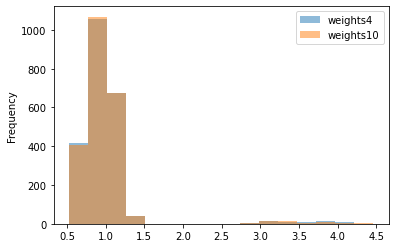

In [264]:
child[['weights4','weights10']].plot.hist(bins=16, alpha=0.5)

array([[<AxesSubplot:title={'center':'weights10'}>,
        <AxesSubplot:title={'center':'weights4'}>]], dtype=object)

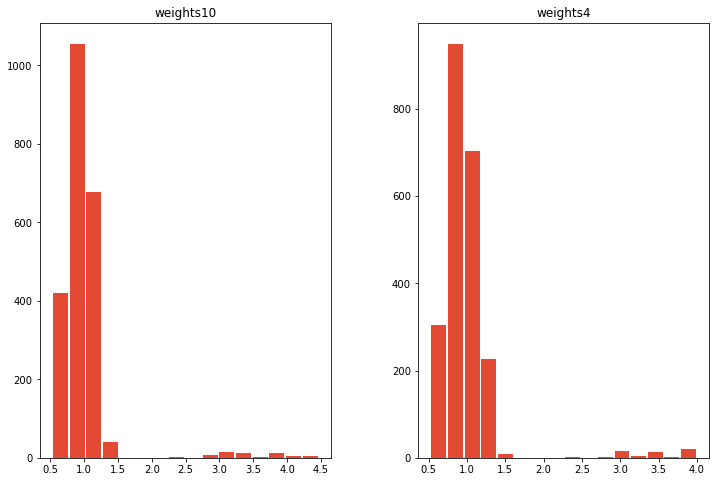

In [260]:
child.hist(column=['weights10','weights4'], bins=16, grid=False, figsize=(12,8), color='#e24a33', zorder=2, rwidth=0.9)

In [255]:
import matplotlib.pyplot as plt

def histogram(df, label, col):
    # 16 = 4 * (1/.0.25)
    if col =='weights10':
        ax = df.hist(column='weights10', bins=16, grid=False, figsize=(12,8), color='#e24a33', zorder=2, rwidth=0.9)
    else:
        ax = df.hist(column='weights4', bins=16, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
        
    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title(label + col)

        # Set x-axis label
        x.set_xlabel("Weights", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Count", labelpad=20, weight='bold', size=12)





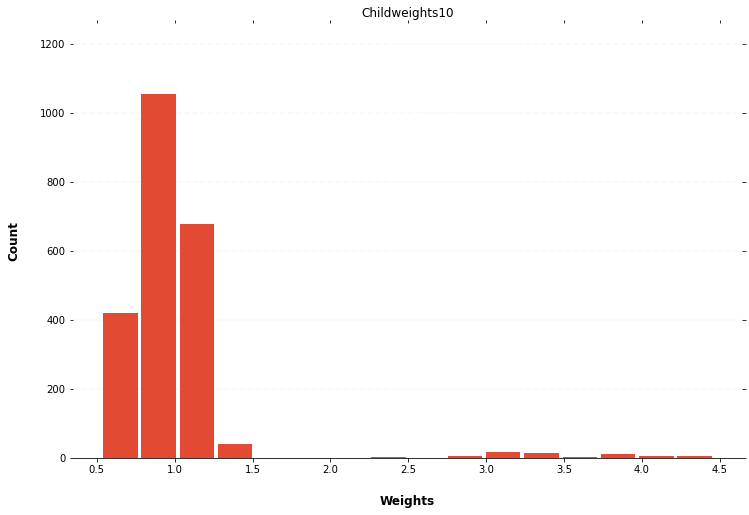

In [256]:
histogram(child, 'Child','weights10')

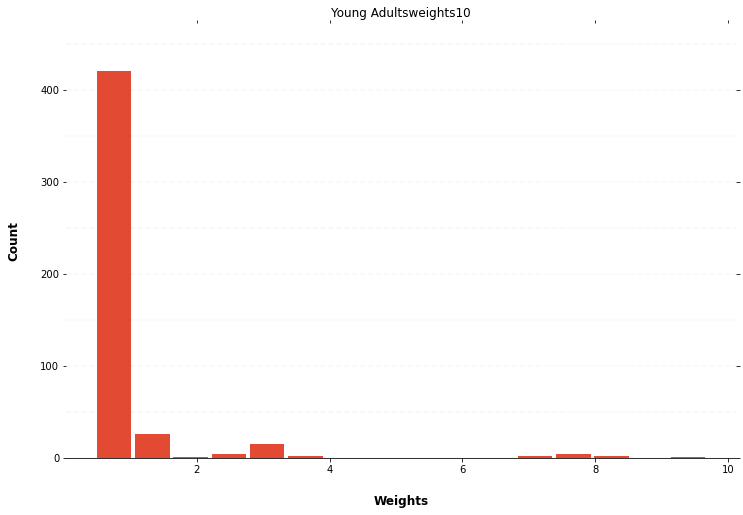

In [257]:
histogram(yadult, 'Young Adults','weights10')

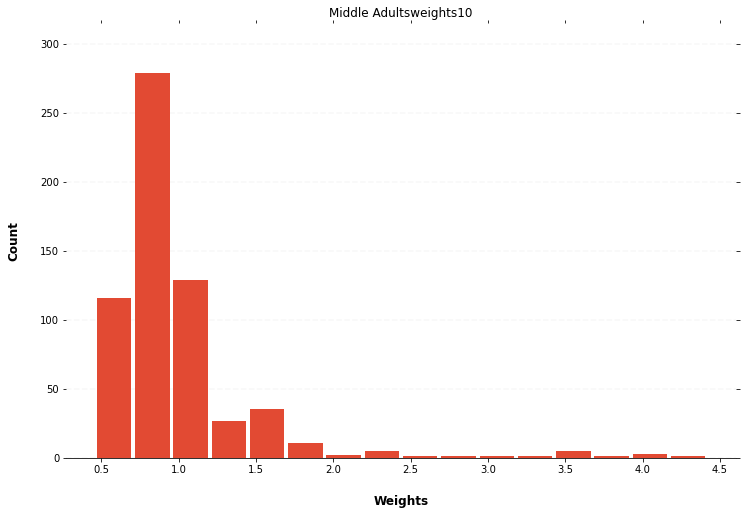

In [258]:
histogram(madult, 'Middle Adults','weights10')

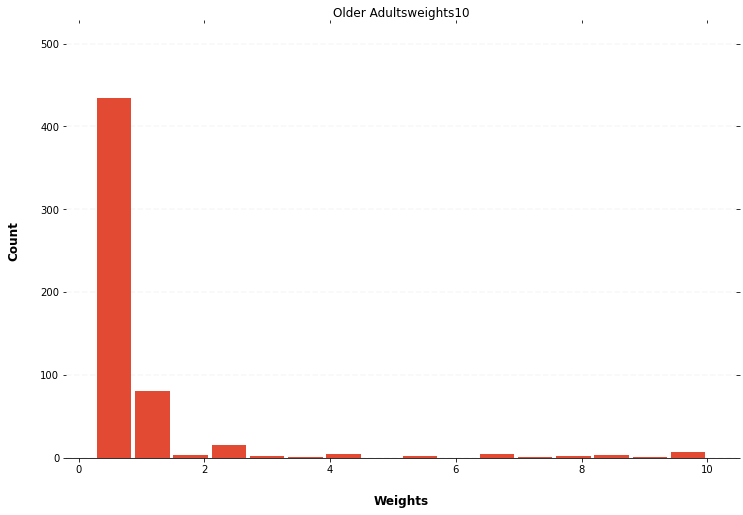

In [259]:
histogram(oadult, 'Older Adults','weights10')

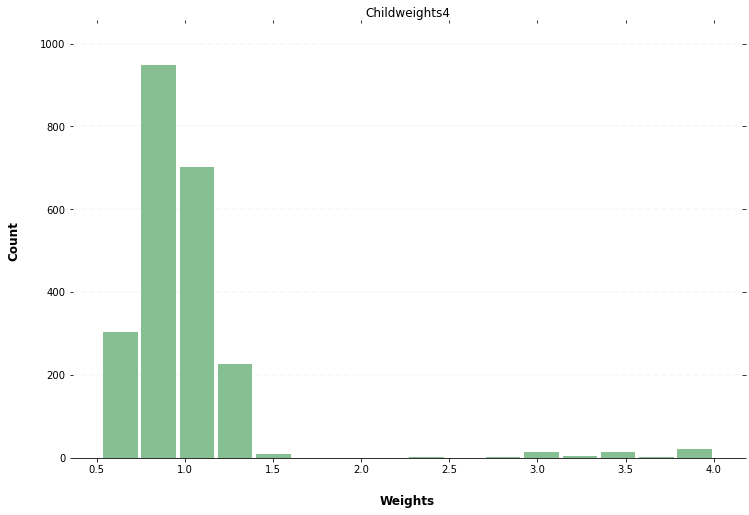

In [265]:
histogram(child, 'Child','weights4')

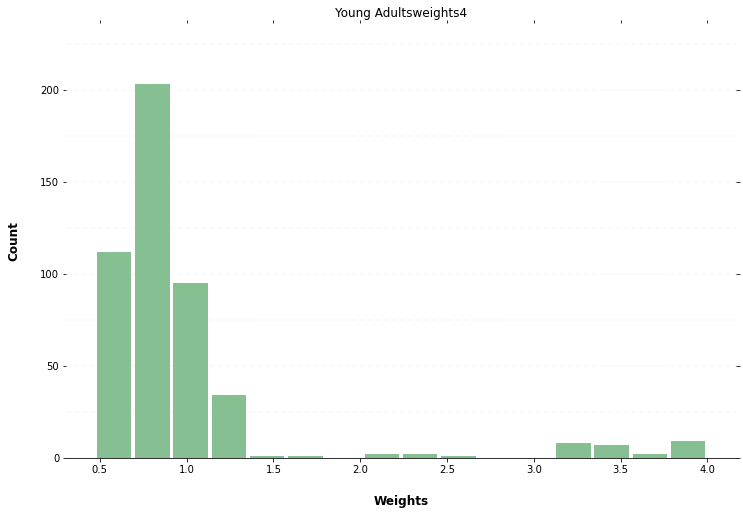

In [268]:
histogram(yadult, 'Young Adults','weights4')

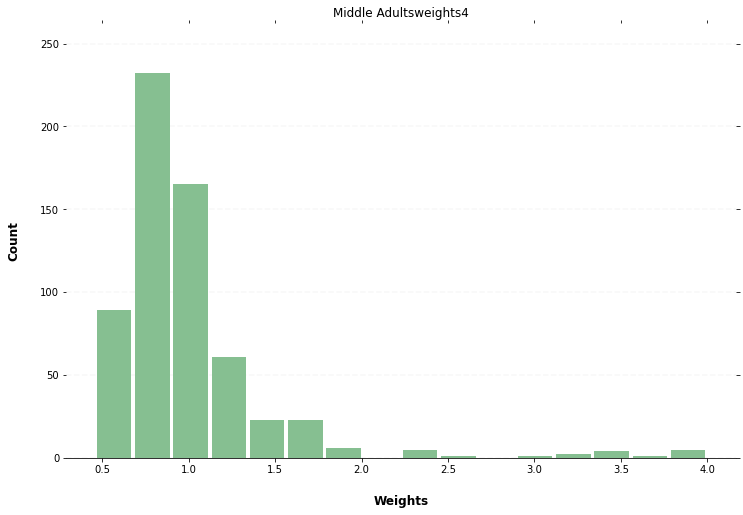

In [267]:
histogram(madult, 'Middle Adults','weights4')

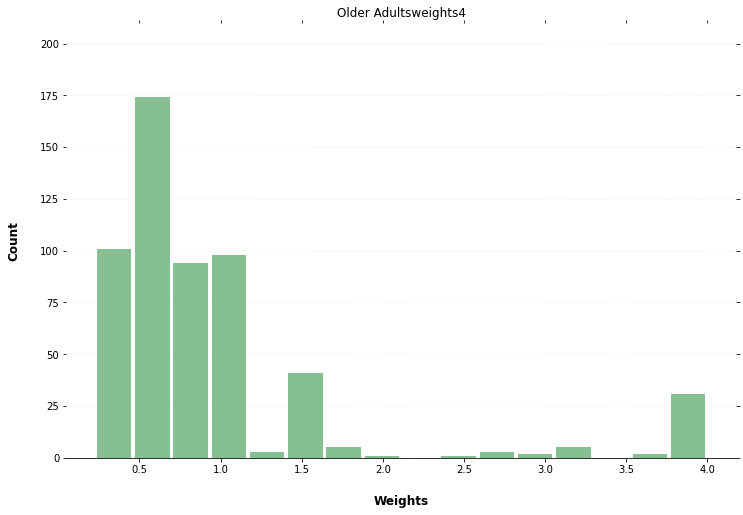

In [266]:
histogram(oadult, 'Older Adults','weights4')

In [241]:
tar = pd.read_csv('C:\\Users\\tsb7592\\Downloads\\ForJulyWeighting\\ChildTargets.csv')
ytar = pd.read_csv('C:\\Users\\tsb7592\\Downloads\\ForJulyWeighting\\YoungAdultTargets.csv')
mtar = pd.read_csv('C:\\Users\\tsb7592\\Downloads\\ForJulyWeighting\\MiddleAdultTargets.csv')
otar = pd.read_csv('C:\\Users\\tsb7592\\Downloads\\ForJulyWeighting\\OlderAdultTargets.csv')

In [243]:
import numpy as np

def obtained_weighted(data, target, edu):
    '''
    Fill the obtained N for race, sex and edu
    Use the raw counts to fill in the “unweighted_N” 
    
    '''
    total = data.shape[0]
    target = target.replace({"Target": edu})
    
    target['name'] = target.REGION.map(str) + "-" + target['Target']
    rr = data.groupby('region.race')['FinalPIN'].count().reset_index()
    rs = data.groupby('region.sex')['FinalPIN'].count().reset_index()
    re = data.groupby('highestEdu')['FinalPIN'].count().reset_index()
    
    comb = pd.merge(target, rr, left_on='name', right_on='region.race', how='left')
    comb['Obtained_N'].fillna(comb['FinalPIN'],inplace=True)
    
    comb = pd.merge(comb, rs, left_on='name', right_on='region.sex', how='left')
    comb['Obtained_N'].fillna(comb['FinalPIN_y'],inplace=True)
    
    comb = pd.merge(comb, re, left_on='Target', right_on='highestEdu', how='left')
    comb['Obtained_N'].fillna(comb['FinalPIN'],inplace=True)
    
    comb['Unweighted_Proportion' ] = comb['Obtained_N']/total
    #display(target)
    #“unweighted_proportion” is the unweighted_N divided by the sum of the unweighted_n grouped-by characteristic. 
    rr = data.groupby('region.race')['weights4'].sum().reset_index()
    rs = data.groupby('region.sex')['weights4'].sum().reset_index()
    re = data.groupby('highestEdu')['weights4'].sum().reset_index()
    
    comb = pd.merge(comb, rr, left_on='name', right_on='region.race', how='left')
    comb['Weighted_Proportion'].fillna(comb['weights4'],inplace=True)
    
    comb = pd.merge(comb, rs, left_on='name', right_on='region.sex', how='left')
    comb['Weighted_Proportion'].fillna(comb['weights4_y'],inplace=True)
    
    comb = pd.merge(comb, re, left_on='Target', right_on='highestEdu', how='left')
    comb['Weighted_Proportion'].fillna(comb['weights4'],inplace=True)    
    
    comb['Weighted_Proportion' ] =comb['Weighted_Proportion' ] /total
    
    
    comb['Unweighted_Difference'] = comb['Unweighted_Proportion'] - comb['Proportion']
    comb['Weighted_Difference'] = comb['Weighted_Proportion'] - comb['Proportion']
    return comb.iloc[:,:10]

In [244]:
ctar =obtained_weighted(child, tar, pedu)
ctar.tail()

,ageCat,REGION,Characteristic,Target,Proportion,Obtained_N,Unweighted_Proportion,Weighted_Proportion,Unweighted_Difference,Weighted_Difference
27,1,4,SEX,Male,0.1235,271.0000,0.1206,0.1235,-0.0029,-0.0000
28,1,0,ParentalEd,less than high school graduate,0.0895,58.0000,0.0258,0.0895,-0.0637,0.0000
29,1,0,ParentalEd,high school graduate,0.2418,561.0000,0.2496,0.2418,0.0078,0.0000
30,1,0,ParentalEd,some college,0.2506,721.0000,0.3207,0.2506,0.0701,-0.0000
31,1,0,ParentalEd,four year or higher degree,0.4181,908.0000,0.4039,0.4181,-0.0142,0.0000


In [245]:
ytar =obtained_weighted(yadult, ytar, sedu)
ytar.tail()

,ageCat,REGION,Characteristic,Target,Proportion,Obtained_N,Unweighted_Proportion,Weighted_Proportion,Unweighted_Difference,Weighted_Difference
28,2,0,SelfEd,less than high school graduate,0.1485,9.0000,0.0189,0.0755,-0.1296,-0.0730
29,2,0,SelfEd,high school graduate,0.3188,221.0000,0.4633,0.3461,0.1445,0.0273
30,2,0,SelfEd,some college,0.4042,224.0000,0.4696,0.4389,0.0654,0.0347
31,2,0,SelfEd,Bachelors/4-year degree,0.1197,19.0000,0.0398,0.1300,-0.0799,0.0103
32,2,0,SelfEd,Advanced Degree,0.0088,4.0000,0.0084,0.0096,-0.0004,0.0008


In [246]:
mtar =obtained_weighted(madult, mtar, sedu)
mtar.tail()

,ageCat,REGION,Characteristic,Target,Proportion,Obtained_N,Unweighted_Proportion,Weighted_Proportion,Unweighted_Difference,Weighted_Difference
25,3,0,SelfEd,less than high school graduate,0.0815,15.0000,0.0243,0.0815,-0.0572,0.0000
26,3,0,SelfEd,high school graduate,0.2610,170.0000,0.2751,0.2610,0.0141,0.0000
27,3,0,SelfEd,some college,0.2532,191.0000,0.3091,0.2532,0.0559,0.0000
28,3,0,SelfEd,Bachelors/4-year degree,0.2576,159.0000,0.2573,0.2576,-0.0003,-0.0000
29,3,0,SelfEd,Advanced Degree,0.1467,83.0000,0.1343,0.1467,-0.0124,-0.0000


In [248]:
otar =obtained_weighted(oadult, otar, sedu)
otar.tail()

,ageCat,REGION,Characteristic,Target,Proportion,Obtained_N,Unweighted_Proportion,Weighted_Proportion,Unweighted_Difference,Weighted_Difference
25,4,0,SelfEd,less than high school graduate,0.1043,7.0000,0.0125,0.0499,-0.0918,-0.0544
26,4,0,SelfEd,high school graduate,0.3121,182.0000,0.3244,0.3490,0.0123,0.0369
27,4,0,SelfEd,some college,0.2542,147.0000,0.2620,0.2734,0.0078,0.0192
28,4,0,SelfEd,Bachelors/4-year degree,0.1921,129.0000,0.2299,0.1926,0.0378,0.0005
29,4,0,SelfEd,Advanced Degree,0.1374,96.0000,0.1711,0.1350,0.0337,-0.0024


In [249]:
ctar.to_csv('C:\\Users\\tsb7592\\Downloads\\ChildTargets.csv', index=False)
ytar.to_csv('C:\\Users\\tsb7592\\Downloads\\YoungAdultTargets.csv', index=False)
mtar.to_csv('C:\\Users\\tsb7592\\Downloads\\MiddleAdultTargets.csv', index=False)
otar.to_csv('C:\\Users\\tsb7592\\Downloads\\OlderAdultTargets.csv' ,index=False)